In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gaitFunctions
import plotClip
import seaborn as sns

In [4]:
# navigate to a directory that contains some data
os.chdir('/Users/iwoods/Desktop/working')
# for f in sorted(glob.glob('*')):
#     print(f)
excel_file = 'iw_21Dec_exemplaris_tardigrade03_107-117.xlsx'
xl = pd.ExcelFile(excel_file)
gait_df = xl.parse('gait_styles')
gait_df.head(3)

,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed
0,0.0303,0.068901,0.285361,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN
1,0.0606,0.069358,0.287256,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN
2,0.0909,0.069511,0.287891,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN


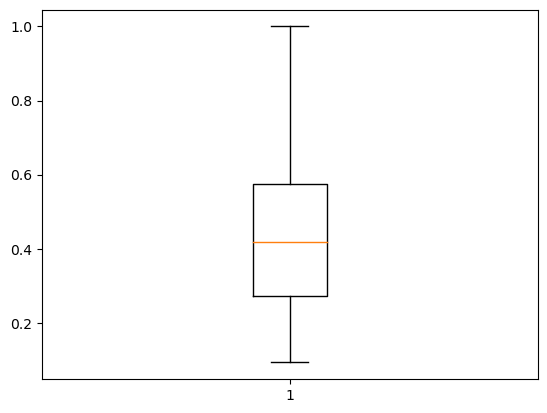

In [13]:
gait_style = 'tetrapod' 
coordination_col = gait_style + '_coordination'
if coordination_col in gait_df.columns:
    # get all the non-nan values in this column
    colvals = gait_df[coordination_col].values
    colvals = colvals[~np.isnan(colvals)]
    plt.boxplot(colvals)
    plt.show()

# Tetrapod Coordination Strength (or tripod)
This is all now in analyzeSteps

In [5]:
# navigate to a directory that contains some data
os.chdir('/Users/iwoods/Desktop/working')
for f in sorted(glob.glob('*')):
    print(f)

iw_21Dec_exemplaris_tardigrade03_107-117.mov
iw_21Dec_exemplaris_tardigrade03_107-117.xlsx


In [14]:
excel_file = 'iw_21Dec_exemplaris_tardigrade03_107-117.xlsx'
xl = pd.ExcelFile(excel_file)
sheets = xl.sheet_names  # see all sheet names
for sheet in sheets:
    print(sheet)

identity
pathtracking
path_stats
steptracking_0-9
step_timing
step_stats
gait_styles


In [18]:
gait_df = xl.parse('gait_styles')
gait_df.head(3)

,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear
0,0.0303,0.068901,0.285361,tetrapod_canonical,L1_R2,step,R4
1,0.0606,0.069358,0.287256,tetrapod_canonical,L1_R2,step,R4
2,0.0909,0.069511,0.287891,tetrapod_canonical,L1_R2,step,R4


In [20]:
def combineSteptracking(excel_file):
    
    '''
    combine steptracking data from all sheets within an excel file
    into two dictionaries of stances and swings
    key = legs
    '''
    
    xl = pd.ExcelFile(excel_file)
    sheets = xl.sheet_names
    steptracking_sheets = sorted([x for x in sheets if 'steptracking' in x ])
    
    stances = {}
    swings = {}
    
    for sheet in steptracking_sheets:
        mov_data_df = xl.parse(sheet)
        leg_states = mov_data_df.leg_state.values
        leg_times = mov_data_df.times.values
        for i,state in enumerate(leg_states):
            leg = state.split('_')[0]
            if 'down' in state:
                stances_leg = np.array([float(x) for x in leg_times[i].split()])
                if leg in stances:
                    stances[leg].extend(stances_leg)
                else:
                    stances[leg] = stances_leg
            elif 'up' in state:
                swings_leg = np.array([float(x) for x in leg_times[i].split()])
                if leg in swings:
                    swings[leg].extend(swings_leg)
                else:
                    swings[leg] = swings_leg
                    
    # done collecting stances and swings ... put them in order
    for leg in stances.keys():
        stances[leg] = np.sort(stances[leg])
        swings[leg] = np.sort(swings[leg])
        
    return stances, swings

def truncToThree(flt):
    '''
    truncate a floating point decimal to three decimal places (not rounded)
    '''
    return int(flt*1000)/1000

def calculateCoordination(gait_styles_df, gait_style, stances, swings):
    
    '''
    Calculate 'coordination strength' for a specified gait_style ('tetrapod' or 'tripod')
    This only considers bouts of 'canonical' gait
    
    Inputs:
    gait_styles_df: DataFrame - loaded from gait_styles sheet
    gait_style: String - 'tetrapod' or 'tripod'
    stances: Dictionary - keys are leg names, values are numpy arrays of stance times
    swings: Dictionary (similar to stances)
    
    Returns:
    gait_styles_df with two new columns:
        Coordination strength for each bout of the specified gait_style
        Average speed (in bodylengths / sec) for each bout of the specified gait_style
    '''
    
    # get relevant data
    gait_search = gait_style + '_canonical'
    gaits = gait_styles_df.gaits_lateral.values
    frametimes = gait_styles_df.frametimes.values
    swinging_legs = gait_styles_df.swinging_lateral.values
    speed = gait_styles_df['speed (bodylength/s)'].values

    # initialize empty vector to add to gait_styles_df
    coord_strength_vec = np.empty(len(frametimes))
    coord_strength_vec[:] = np.nan
    coord_speed_vec = np.empty(len(frametimes))
    coord_speed_vec[:] = np.nan
    
    coord_col_name = gait_style + '_coordination'
    speed_col_name = gait_style + '_speed'

    # get timing of start and end of video
    vid_start = truncToThree(frametimes[0])
    vid_end = truncToThree(frametimes[-1])
    
    leg_combo = ''
    
    # go through frames
    for i, frametime in enumerate(frametimes):
    
        # does this frame have the style we are interested in?
        if gaits[i] == gait_search:

            # is it a new combination of legs, aka a new bout?
            leg_str = swinging_legs[i]     
            if leg_str != leg_combo:
                leg_combo = leg_str
                legs = leg_str.split('_')
                lowest_swing = 10000
                bout_start = truncToThree(frametime)
                bout_end = 10000
                highest_stance = 0
                thistime = truncToThree(frametime)
                
                # for each leg, get the times that we need
                for leg in legs:
                    swing_ok = False
                    stance_ok = False
                
                    # get the swing starts at or before start of bout
                    start_swing = np.where(swings[leg] <= thistime)[0]
                    if len(start_swing) > 0:
                        swing_ok = True
                        most_recent_swing = swings[leg][np.max(start_swing)]
                        if most_recent_swing <= lowest_swing:
                            lowest_swing = most_recent_swing
                    
                    # get the stance starts at or after the end of bout
                    next_stance = np.where(stances[leg] >= thistime)[0]
                    if len(next_stance) > 0:
                        stance_ok = True
                        next_step = stances[leg][np.min(next_stance)]
                        if next_step >= highest_stance:
                            highest_stance = next_step
                        if next_step <= bout_end:
                            bout_end = next_step
                
                if swing_ok and stance_ok:
                    # now, we have the four times we need:
                    # lowest_swing, highest_swing, lowest_stance, highest_stance
                    # does the timing overlap with the start or end of the video (inefficient!)
                    if lowest_swing > vid_start and highest_stance < vid_end:
                        
                        # calculate coordination strength for this bout
                        coordination_strength = (bout_end - bout_start) / (highest_stance-lowest_swing) 
                        coord_strength_vec[i] = coordination_strength
                        
                        # calculate average speed (bodylength/sec) for this bout
                        end_frame = np.max(np.where(frametimes<=bout_end)[0])
                        avg_speed = np.mean(speed[i:end_frame+1])
                        coord_speed_vec[i] = avg_speed
                        
#                         print(lowest_swing, bout_start, bout_end, highest_stance, avg_speed, i, end_frame) # testing
   
    # finished going through frames, add columns of new data to dataframe
    gait_styles_df[coord_col_name] = coord_strength_vec
    gait_styles_df[speed_col_name] = coord_speed_vec
    
    return gait_styles_df

stances, swings = combineSteptracking(excel_file)

for gait_style in ['tetrapod','tripod']:
    gait_styles_df = calculateCoordination(gait_df, gait_style, stances, swings)
    
    

In [21]:
gait_styles_df.head(3)

,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed
0,0.0303,0.068901,0.285361,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN
1,0.0606,0.069358,0.287256,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN
2,0.0909,0.069511,0.287891,tetrapod_canonical,L1_R2,step,R4,NaN,NaN,NaN,NaN


In [54]:
with pd.ExcelWriter(xl_file, engine='openpyxl', if_sheet_exists='replace', mode='a') as writer: 
    gait_styles_df.to_excel(writer, index=False, sheet_name='gait_styles')